# EDA Netflix

Code written by Stijn, adapted by me and ran in my computer to validate the sample that I used in the models.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # to make jupyter print all outputs, not just the last one
from IPython.core.display import HTML # to pretty print pandas df and be able to copy them over (e.g. to ppt slides)

In [3]:
# df = pd.read_parquet('cleaned/netflix_parquet')
df = pd.read_parquet('cleaned/netflix_parquet')

Let us take a look at the dataframe we created after joining the movietitles and extracting the release year from the movie titles from the netflix prize dataset. You will notice the use of dictionaries which store the review data per movieId. 

We did this to decrease the memory usage the dataset is using, but also to include more movieids in a smaller sample. One movie contains multiple reviews, so taking more rows of the original dataset which is not grouped by movieId, would mean less different movieIds in a sample to train the recommender system with.

In the code, you will notice many functions/for loops which will unpack the dictionary to get ahold off the stored data.

In [4]:
# look at dataframe, first row and the dictionaries created during joining and merging the netflix prize dataset
df
df.iloc[0]
df['review_data'].iloc[0]

,movieId,year,title,review_data,genres
0,1,2003,Dinosaur Planet,"[{'date': 2005-09-06, 'rating': 3.0, 'userId':...","[Documentary, Animation, Family]"
1,2,2004,Isle of Man TT 2004 Review,"[{'date': 2005-09-05, 'rating': 4.0, 'userId':...",None
2,3,1997,Character,"[{'date': 2003-03-29, 'rating': 4.0, 'userId':...","[Crime, Drama, Mystery]"
3,4,1994,Paula Abdul's Get Up & Dance,"[{'date': 2005-09-06, 'rating': 3.0, 'userId':...",[Family]
4,5,2004,The Rise and Fall of ECW,"[{'date': 2005-02-08, 'rating': 5.0, 'userId':...","[Documentary, Sport]"
...,...,...,...,...,...
1957,1958,2002,WWE: Before They Were Superstars 2,"[{'date': 2005-06-16, 'rating': 2.0, 'userId':...","[Documentary, Sport]"
1958,1959,1961,Splendor in the Grass,"[{'date': 2005-07-07, 'rating': 4.0, 'userId':...","[Drama, Romance]"
1959,1960,2003,Smack: Vol. 1,"[{'date': 2004-09-22, 'rating': 3.0, 'userId':...",None
1960,1961,1939,Port of Shadows,"[{'date': 2005-08-12, 'rating': 3.0, 'userId':...",None


movieId                                                        1
year                                                        2003
title                                            Dinosaur Planet
review_data    [{'date': 2005-09-06, 'rating': 3.0, 'userId':...
genres                          [Documentary, Animation, Family]
Name: 0, dtype: object

array([{'date': datetime.date(2005, 9, 6), 'rating': 3.0, 'userId': '1488844'},
       {'date': datetime.date(2005, 5, 13), 'rating': 5.0, 'userId': '822109'},
       {'date': datetime.date(2005, 10, 19), 'rating': 4.0, 'userId': '885013'},
       {'date': datetime.date(2005, 12, 26), 'rating': 4.0, 'userId': '30878'},
       {'date': datetime.date(2004, 5, 3), 'rating': 3.0, 'userId': '823519'},
       {'date': datetime.date(2005, 11, 17), 'rating': 3.0, 'userId': '893988'},
       {'date': datetime.date(2004, 8, 5), 'rating': 4.0, 'userId': '124105'},
       {'date': datetime.date(2004, 4, 22), 'rating': 3.0, 'userId': '1248029'},
       {'date': datetime.date(2004, 5, 9), 'rating': 4.0, 'userId': '1842128'},
       {'date': datetime.date(2005, 5, 11), 'rating': 3.0, 'userId': '2238063'},
       {'date': datetime.date(2005, 5, 19), 'rating': 4.0, 'userId': '1503895'},
       {'date': datetime.date(2005, 6, 6), 'rating': 5.0, 'userId': '2207774'},
       {'date': datetime.date(2004, 8

So the dataset consists off the id, title, release year and corresponding reviews, where the userId, rating and date are appended in dictionaries. 

### Some general findings about Netflix Prize dataframe:

In [5]:
# Extract all user IDs from the 'review_data' column using list comprehension
user_ids = [review_entry.get('userId') for row in df['review_data'] for review_entry in row if review_entry.get('userId')]

# Count the number of unique users and reviews
unique_users = set(user_ids)
amount_of_reviews = len(user_ids)

# Calculate averages
avg_reviews_per_unique_user = amount_of_reviews / len(unique_users)
avg_reviews_per_movie_id = amount_of_reviews / len(df)

# Print results
print("There are {} reviews in the NETFLIX dataframe.".format(amount_of_reviews))
print("There are {} unique users who have reviewed a movie.".format(len(unique_users)))
print("There are {} movieIds in the NETFLIX dataset.".format(len(df)))
print("A unique user places {} reviews on average in the NETFLIX dataset.".format(round(avg_reviews_per_unique_user)))
print("A movieId receives {} reviews on average in the NETFLIX dataset.".format(round(avg_reviews_per_movie_id)))

There are 9998038 reviews in the NETFLIX dataframe.
There are 447835 unique users who have reviewed a movie.
There are 1962 movieIds in the NETFLIX dataset.
A unique user places 22 reviews on average in the NETFLIX dataset.
A movieId receives 5096 reviews on average in the NETFLIX dataset.


## What sample to take before doing EDA and creating the recommender system:

The complete dataset is handled above, from now on we will work with a representative sample to decrease memory usage and ease of use. The df dataframe will be randomly splitted into multiple samples with different sizes, with replacement(or with duplicates):

### Let's define some functions so we can replicate our work for more samples easily:

In [6]:
import datetime
from scipy.stats import f_oneway

def get_month_name(month_num):
    """
    Convert a numeric month to its corresponding name.

    Parameters:
    month_num (int): Numeric representation of a month (1-12).

    Returns:
    str: Name of the month.
    """
    return datetime.date(1900, month_num, 1).strftime('%B')

def extract_rating_date_plot_freq(df_list):
    """
    Extract ratings data from a list of DataFrames and plot the frequency of ratings per month.

    Parameters:
    df_list (list): List of DataFrames containing ratings data.

    Returns:
    None
    """
    plt.figure(figsize=(12, 8))
    for idx, df in enumerate(df_list):
        var_name = [name for name, value in globals().items() if value is df][0]
        ratings_per_month = {month: 0 for month in range(1, 13)}
        for row in df['review_data'].values:
            for entry in row:
                month = entry['date'].month
                ratings_per_month[month] += 1

        months = list(ratings_per_month.keys())
        freq = list(ratings_per_month.values())
    
        plt.bar(months, freq, alpha=0.5, label=var_name)

        # Add text labels on top of each bar
        for month, f in zip(months, freq):
            plt.text(month, f, str(f), ha='center', va='bottom')

    plt.xlabel('Month')
    plt.ylabel('Frequency')
    plt.title('Frequency of Ratings per Month')
    plt.legend()
    plt.xticks(range(1, 13), [get_month_name(month) for month in range(1, 13)], rotation=90)  # Rotate x-axis labels
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

def extract_count_rating_per_movie_and_plot(df_list, term):
    """
    Extract average rating per movie from a list of DataFrames and plot the distribution.

    Parameters:
    df_list (list): List of DataFrames containing ratings data.
    term (str): Term specifying the type of rating to extract (e.g., 'rating', 'usefulness').

    Returns:
    None
    """
    plt.figure(figsize=(12, 8))
    for df in df_list:
        var_name = [name for name, value in globals().items() if value is df][0]
        avg_ratings = []
        for row in df['review_data'].values:
            ratings = [entry[term] for entry in row]
            avg_rating = len(ratings)
            avg_ratings.append(avg_rating)  
        plt.hist(avg_ratings, bins=20, alpha=0.5, label=var_name, density=True)  # Adjust the number of bins as needed
    plt.xlabel('Count of {}'.format(term))
    plt.ylabel('Density')
    plt.title('Distribution of counts of {} per movie'.format(term))
    plt.legend()
    plt.show()
    
from scipy.stats import kruskal

def extract_rating_kruskal_wallis(df_list):
    """
    Perform Kruskal-Wallis test on ratings data from a list of DataFrames.

    Parameters:
    df_list (list): List of DataFrames containing ratings data.

    Returns:
    pandas.DataFrame: DataFrame containing Kruskal-Wallis test results including H-statistic, p-value, and whether to reject the null hypothesis.
    """
    results = []
    for df in df_list:
        var_name = [name for name, value in globals().items() if value is df][0]
        ratings_per_month = {month: [] for month in range(1, 13)}
        total_ratings = 0
        for row in df['review_data'].values:
            for entry in row:
                month = entry['date'].month
                rating = entry['rating']
                ratings_per_month[month].append(entry['rating'])
                total_ratings += 1

        kruskal_data = [ratings_per_month[month] for month in range(1, 13)]
        h_statistic, p_value = kruskal(*kruskal_data)
        results.append({'Sample': var_name, 'H-Statistic': h_statistic, 'P-value': p_value,'Amount of MovieIds':len(df),'Amount of Ratings': total_ratings})

    results_df = pd.DataFrame(results)
    results_df['Reject Null Hypotheses'] = results_df['P-value'] < 0.05

    return results_df

def compare_genre_frequencies(df1, df2):
    """
    Create a frequency plot comparing the genres' frequencies between two dataframes.

    Parameters:
    df1 (DataFrame): First DataFrame containing genres data.
    df2 (DataFrame): Second DataFrame containing genres data.

    Returns:
    None
    """
    # Flatten the lists of genres for both dataframes
    all_genres_df1 = [genre for sublist in df1['genres'] if sublist is not None for genre in sublist]
    all_genres_df2 = [genre for sublist in df2['genres'] if sublist is not None for genre in sublist]

    # Count the frequencies of genres in both dataframes
    genre_counts_df1 = {genre: all_genres_df1.count(genre) for genre in set(all_genres_df1)}
    genre_counts_df2 = {genre: all_genres_df2.count(genre) for genre in set(all_genres_df2)}

    # Plot the frequencies
    plt.figure(figsize=(12, 8))  # Set figure size for better visualization
    plt.bar(genre_counts_df1.keys(), genre_counts_df1.values(), alpha=0.5, label='Sample DF')
    plt.bar(genre_counts_df2.keys(), genre_counts_df2.values(), alpha=0.5, label='DF')
    plt.xlabel('Genre')
    plt.ylabel('Frequency')
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()
    
def compare_genre_frequencies(df1, df2):
    """
    Compare the frequencies of genres between two dataframes and plot the results.

    Parameters:
    df1 (DataFrame): First DataFrame containing genres data.
    df2 (DataFrame): Second DataFrame containing genres data.

    Returns:
    None
    """
    # Flatten the lists of genres for both dataframes, skipping None values
    all_genres_df1 = [genre for sublist in df1['genres'] if sublist is not None for genre in sublist]
    all_genres_df2 = [genre for sublist in df2['genres'] if sublist is not None for genre in sublist]

    # Count the frequencies of genres in both dataframes
    genre_counts_df1 = {genre: all_genres_df1.count(genre) for genre in set(all_genres_df1)}
    genre_counts_df2 = {genre: all_genres_df2.count(genre) for genre in set(all_genres_df2)}

    # Sort genre counts dictionaries by frequency in descending order
    genre_counts_df1_sorted = dict(sorted(genre_counts_df1.items(), key=lambda item: item[1], reverse=True))
    genre_counts_df2_sorted = dict(sorted(genre_counts_df2.items(), key=lambda item: item[1], reverse=True))

    # Plot the genre frequencies
    plt.figure(figsize=(12, 8))  # Set the figure size
    plt.bar(genre_counts_df1_sorted.keys(), genre_counts_df1_sorted.values(), alpha=0.5, label='Sample DF')
    plt.bar(genre_counts_df2_sorted.keys(), genre_counts_df2_sorted.values(), alpha=0.5, label='DF')

    # Add text labels on top of each bar
    for genre, freq in genre_counts_df1_sorted.items():
        plt.text(genre, freq, str(freq), ha='center', va='bottom', rotation=90)
    for genre, freq in genre_counts_df2_sorted.items():
        plt.text(genre, freq, str(freq), ha='center', va='bottom', rotation=90)

    plt.xlabel('Genre')
    plt.ylabel('Frequency')
    plt.title('Comparison of Genre Frequencies')
    plt.legend()
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

### Taking a representative sample

Below, we will do the following things to find a representative sample of the Netflix dataset, to lower computational weight. 

- First, by using stratified sampling, the total data will be divided into quantiles based on amount of reviews. By adjusting the boundaries a properly balanced distribution of movies with specific amounts of reviews, statified samples will take equal amounts of movieIds randomly out of each stratum. 

- Secondly, we will eye-ball the distributions and other EDA results such as differences between groups.

- Thirdly, we will then statistically test with **an independent sample t-test** if the stratums have show signficant difference in mean with the same stratum of the total population, if the null hypothese cannot be rejected across all strata, we will know the sample is representative. In other words, we will have accounted for the differences in amount of ratings in movies by taking the average in a representative way.  

In [7]:
# Step 1: Count the number of dictionaries per row in the review_data column
df['num_reviews'] = df['review_data'].apply(lambda x: len(x))

# Step 2: Divide the dataset into strata based on the number of reviews for each movie
quintiles = df['num_reviews'].quantile([0, 0.20, 0.40, 0.60, 0.80, 1.0])
# Adjust the boundaries to include fewer movies with a large number of reviews
stratum_boundaries = [0, quintiles[0.40], quintiles[0.60], quintiles[0.80], quintiles[1.0]]
stratum_labels = ['Q1', 'Q2', 'Q3', 'Q4-Q5']

# Create a new column to categorize movies into strata based on the number of reviews
df['review_stratum'] = pd.cut(df['num_reviews'], bins=stratum_boundaries, labels=stratum_labels)

In [8]:
import random

sampled_df = df[df.columns]

# Step 1: Count the number of dictionaries per row in the review_data column
sampled_df['num_reviews'] = sampled_df['review_data'].apply(lambda x: len(x))

# Step 2: Divide the dataset into strata based on the number of reviews for each movie
quintiles = sampled_df['num_reviews'].quantile([0, 0.20, 0.40, 0.60, 0.80, 1.0])
# Adjust the boundaries to include fewer movies with a large number of reviews
stratum_boundaries = [0, quintiles[0.40], quintiles[0.60], quintiles[0.80], quintiles[1.0]]
stratum_labels_before_testing = ['Q1', 'Q2', 'Q3', 'Q4-Q5']

# Create a new column to categorize movies into strata based on the number of reviews
sampled_df['review_stratum'] = pd.cut(sampled_df['num_reviews'], bins=stratum_boundaries, labels=stratum_labels_before_testing)

# Step 3: Define sample size per stratum
sample_size_per_stratum = 20

# Step 4: Within each stratum, apply random sampling techniques to select movies
sampled_movies = []

# Iterate over each stratum
for stratum in sampled_df['review_stratum'].dropna().unique():  # Drop NaN values
    # Filter movies in the current stratum
    stratum_movies = sampled_df[sampled_df['review_stratum'] == stratum]
    
    # Apply simple random sampling to select movies within the stratum
    sampled_indices = random.sample(list(stratum_movies.index), sample_size_per_stratum)
    sampled_movies.extend(sampled_indices)

# Step 5: Create the sampled DataFrame
sampled_df = sampled_df.loc[sampled_movies, ['movieId', 'review_data', 'genres', 'year', 'title', 'review_stratum','num_reviews']]

### Compare some key EDA findings to see wether the samples are representative:

Most column distributions were highly skewed, which indicates that it is not promising to compare that for multiple samples, as the result will be very likely to be the same. Results such as the normality of ratings and the anova results are most important. We will look at those for different samples:

,Sample,H-Statistic,P-value,Amount of MovieIds,Amount of Ratings,Reject Null Hypotheses
0,sampled_df,778.944423,6.276090e-160,80,530497,True
1,___,5622.156250,0.000000e+00,1962,9998038,True


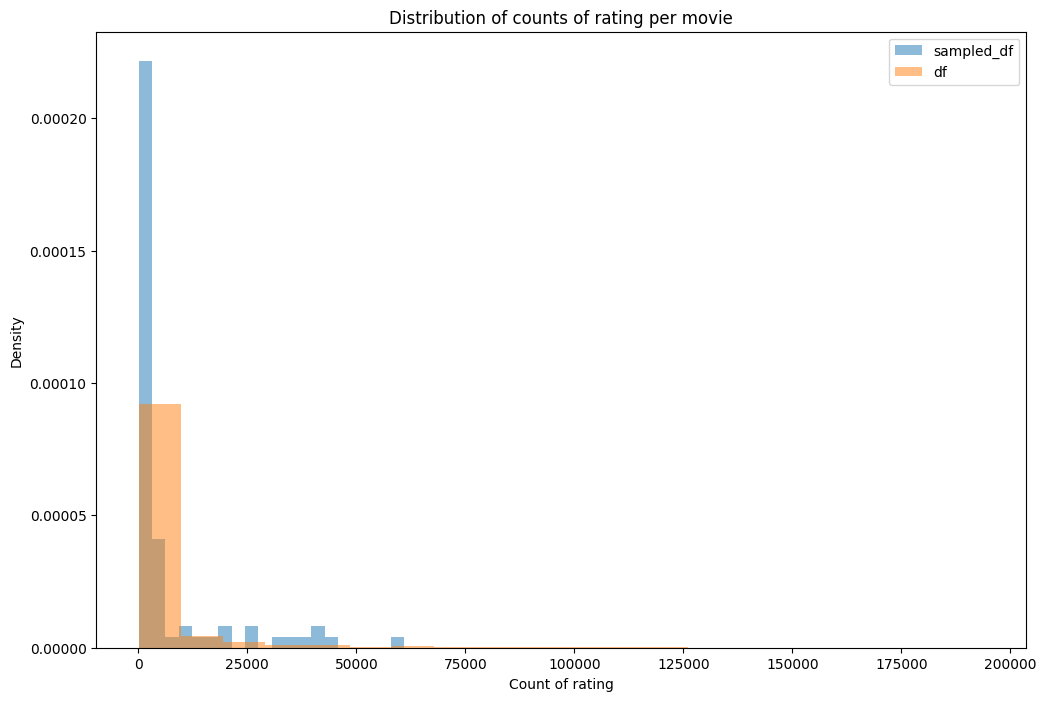

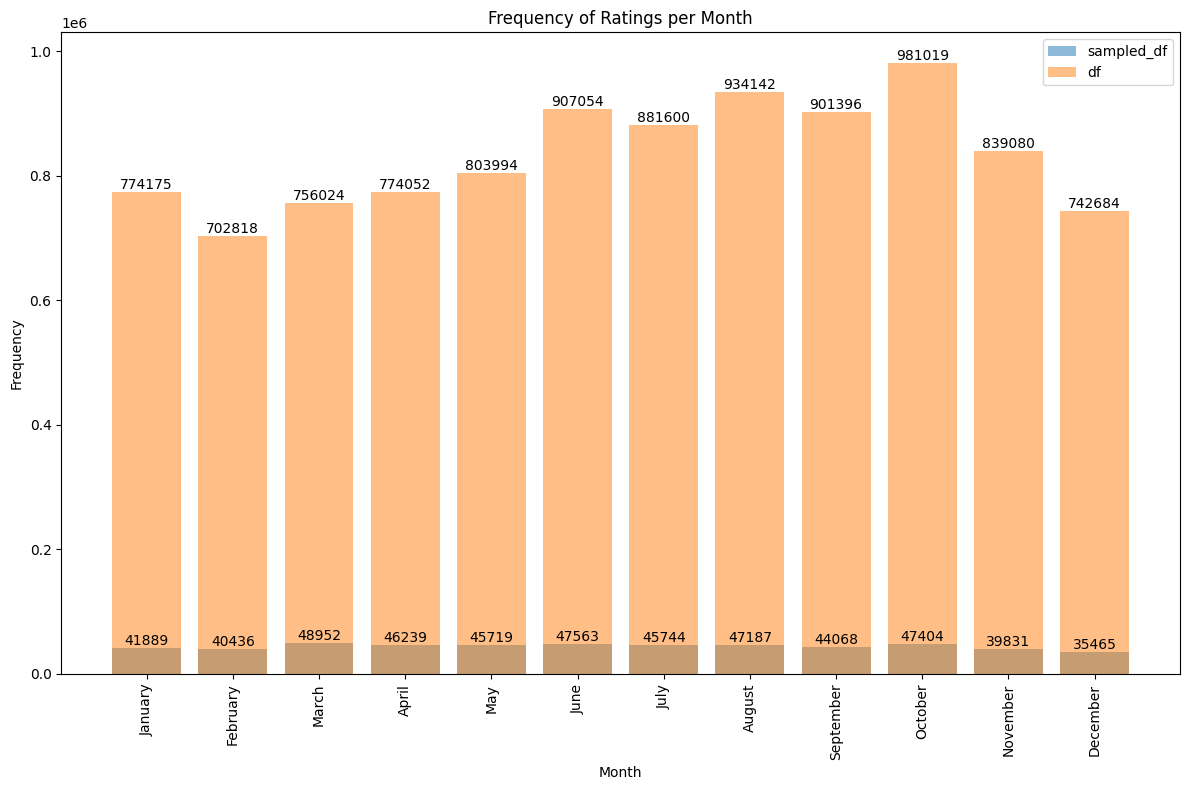

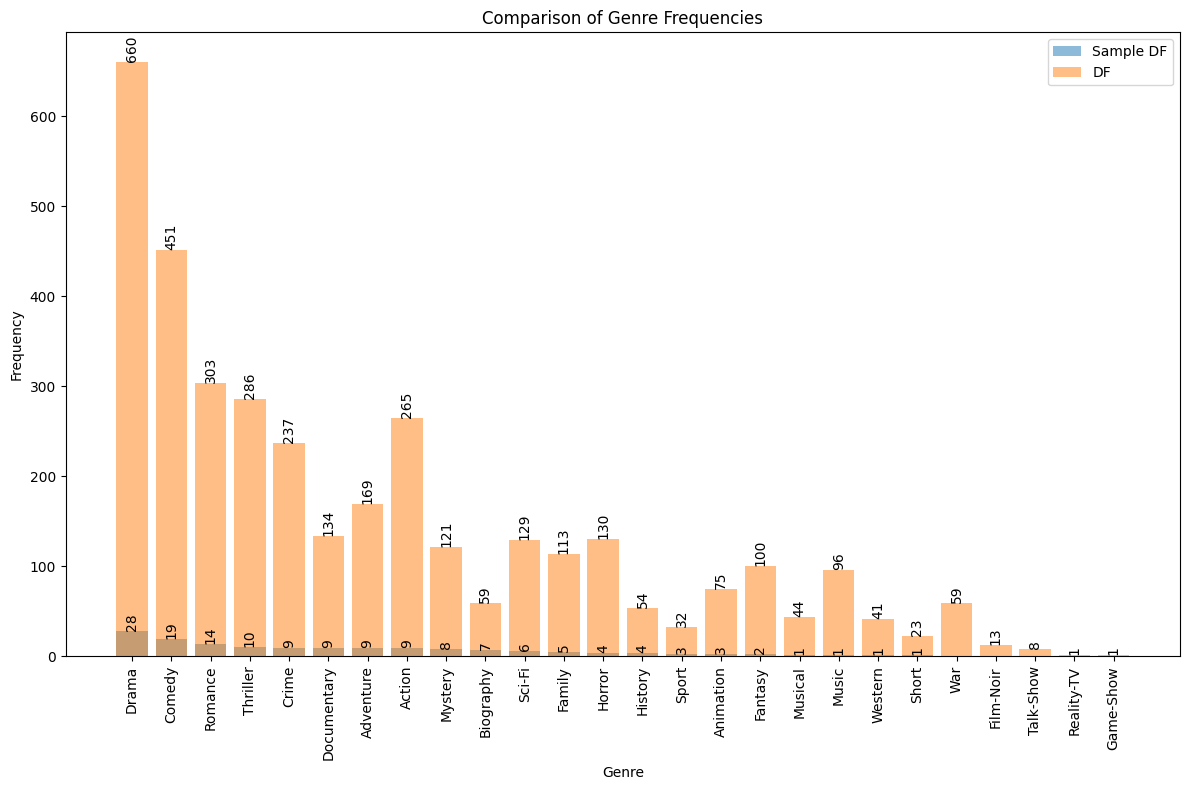

In [9]:
df_list = [sampled_df,df]
extract_rating_kruskal_wallis(df_list)
extract_count_rating_per_movie_and_plot(df_list,'rating')
extract_rating_date_plot_freq(df_list)  
compare_genre_frequencies(sampled_df, df)

It is hard to see whether this is good sample by just eyeballing the graphs. Let's statistically check if the taken sample is representative:

We perform Mann-Whitney U test, as ratings are not normally distributed, so the assumptions to use T-test aren't fullfilled.

In [10]:
from scipy.stats import mannwhitneyu

# Define the strata
strata = sampled_df['review_stratum'].unique()

# Perform Mann-Whitney U test for each stratum
u_statistics = {}
p_values = {}
for stratum in strata:
    # Extract the 'num_reviews' column for the current stratum
    sampled_num_reviews_stratum = sampled_df[sampled_df['review_stratum'] == stratum]['num_reviews']
    population_num_reviews_stratum = df[df['review_stratum'] == stratum]['num_reviews']
    
    # Perform the Mann-Whitney U test
    u_statistic, p_value = mannwhitneyu(sampled_num_reviews_stratum, population_num_reviews_stratum, alternative='two-sided')
    
    # Store the results
    u_statistics[stratum] = u_statistic
    p_values[stratum] = p_value

# Print the results
print("Mann-Whitney U Test Results:")
for stratum in strata:
    print(f"Stratum: {stratum}")
    print(f"U-statistic: {u_statistics[stratum]}")
    print(f"P-value: {p_values[stratum]}")
    alpha = 0.05
    if p_values[stratum] < alpha:
        print("The difference in distributions is statistically significant (reject the null hypothesis)")
    else:
        print("The difference in distributions is not statistically significant (fail to reject the null hypothesis)")

Mann-Whitney U Test Results:
Stratum: Q2
U-statistic: 4598.0
P-value: 0.19213841910304919
The difference in distributions is not statistically significant (fail to reject the null hypothesis)
Stratum: Q1
U-statistic: 7096.0
P-value: 0.463083939672972
The difference in distributions is not statistically significant (fail to reject the null hypothesis)
Stratum: Q3
U-statistic: 4738.0
P-value: 0.115536382316326
The difference in distributions is not statistically significant (fail to reject the null hypothesis)
Stratum: Q4-Q5
U-statistic: 4707.0
P-value: 0.1359223756886934
The difference in distributions is not statistically significant (fail to reject the null hypothesis)


Differences in mean betweens sample and df are not significant, meaning the sample is representatitve.

The Mann-Whitney U test results indicate that there are no statistically significant differences in means across the various strata (Q1 to Q5) of the dataset. In each stratum, the p-values obtained are greater than the typical significance level of 0.05, suggesting that we fail to reject the null hypothesis of no difference in means. 

Therefore, based on these results, we conclude that there is no evidence to suggest that the means of the populations represented by each stratum significantly differ from the overall population mean. However, it's worth noting that there were computational issues preventing the calculation of t-statistics and p-values for Stratum Q2 and Q1, but based on the available information, the same conclusion can be inferred. Overall, this suggests that the distribution of certain characteristics across different strata is consistent with the overall population distribution.

# EDA for Netflix

The EDA for the Netflix dataset starts now.

## Let's look into the columns more deeply:
### When were the most movies released?

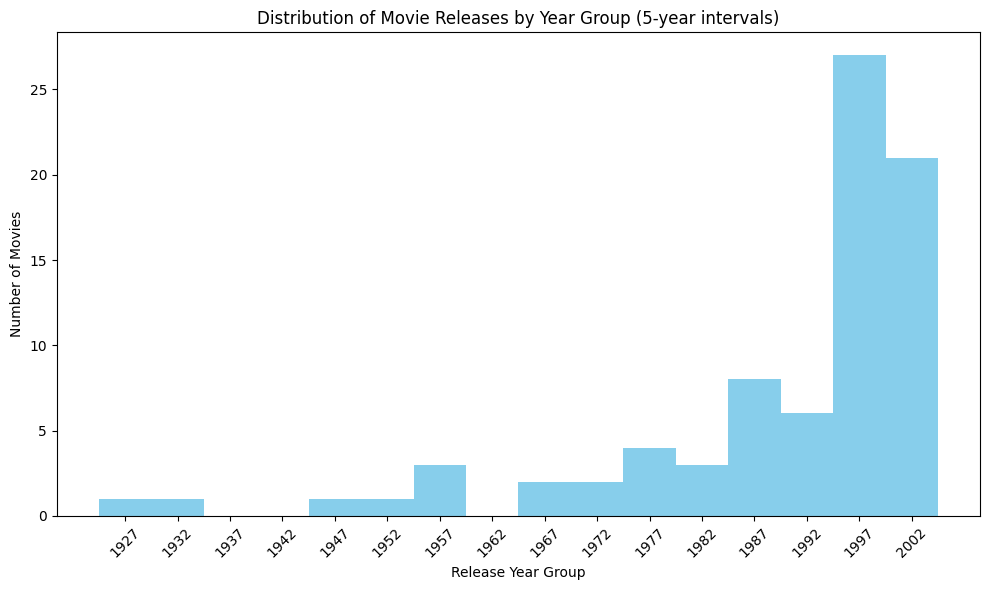

In [11]:
# Define the bin size in years
bin_size = 5

# Extract release years from the 'release_year' column
release_years = (sampled_df['year'].astype(int)).tolist()

# Calculate the minimum and maximum release years to determine the range
min_year = min(release_years)
max_year = max(release_years)

# Initialize dictionary to store counts for each bin
bin_counts = {}

# Count the occurrences of each release year within the corresponding bin
for year in release_years:
    bin_index = (year - min_year) // bin_size
    bin_start_year = min_year + bin_index * bin_size
    if bin_start_year in bin_counts:
        bin_counts[bin_start_year] += 1
    else:
        bin_counts[bin_start_year] = 1

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.bar(bin_counts.keys(), bin_counts.values(), color='skyblue', width=bin_size)
plt.xlabel('Release Year Group')
plt.ylabel('Number of Movies')
plt.title('Distribution of Movie Releases by Year Group ({}-year intervals)'.format(bin_size))
plt.xticks(range(min_year, max_year + 1, bin_size), rotation=45)
plt.tight_layout()
plt.show(); # to dont export text output

Seems like most movies have been released around the 90s and the 00s in the dataset.

### When were the most ratings placed?

<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='Date'>

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Unique users')

Text(0.5, 1.0, 'Reviews placed by unique users per month')

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, '1999'),
  Text(1, 0, '2000'),
  Text(2, 0, '2001'),
  Text(3, 0, '2002'),
  Text(4, 0, '2003'),
  Text(5, 0, '2004'),
  Text(6, 0, '2005')])

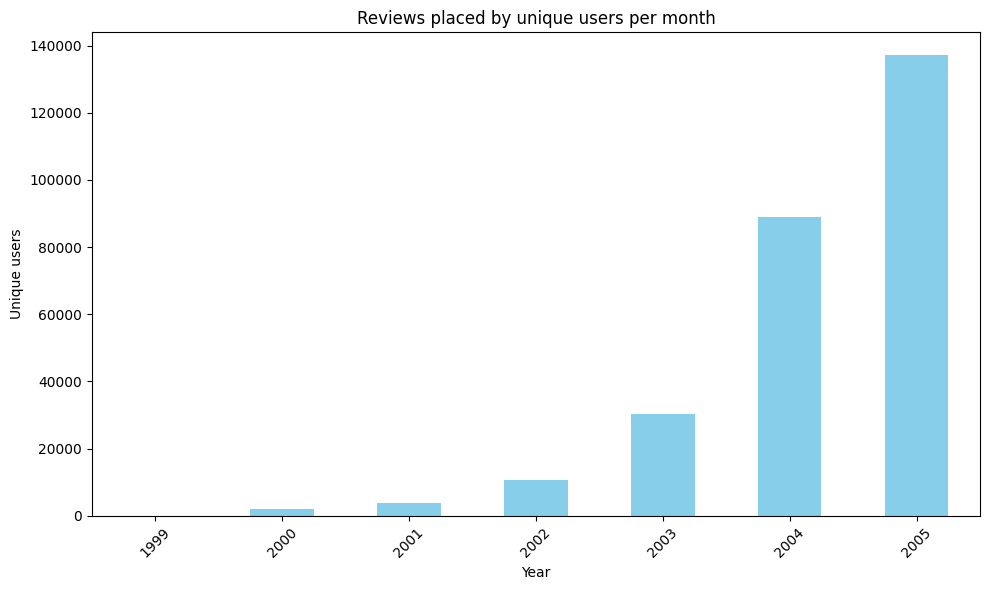

In [12]:
# Extract review dates and user IDs using NumPy
review_data = sampled_df['review_data'].values
review_dates = np.concatenate([np.array([entry['date'] for entry in row]) for row in review_data])
user_ids = np.concatenate([np.array([entry['userId'] for entry in row]) for row in review_data])

# Convert review_dates to pandas datetime objects
review_dates = pd.to_datetime(review_dates)

# Create a DataFrame with review dates and user IDs
review_df = pd.DataFrame({'Date': review_dates, 'User_ID': user_ids})

# Group reviews by month and count the number of unique users for each month
yearly_unique_users = review_df.groupby(review_df['Date'].dt.to_period('Y'))['User_ID'].nunique()

# Plot the number of unique users by month
plt.figure(figsize=(10, 6))
yearly_unique_users.plot(kind='bar', color='skyblue')
plt.xlabel('Year')
plt.ylabel('Unique users')
plt.title('Reviews placed by unique users per month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In 2005, most movies were reviewed by unique users.

### On which days of the week most reviews were placed?

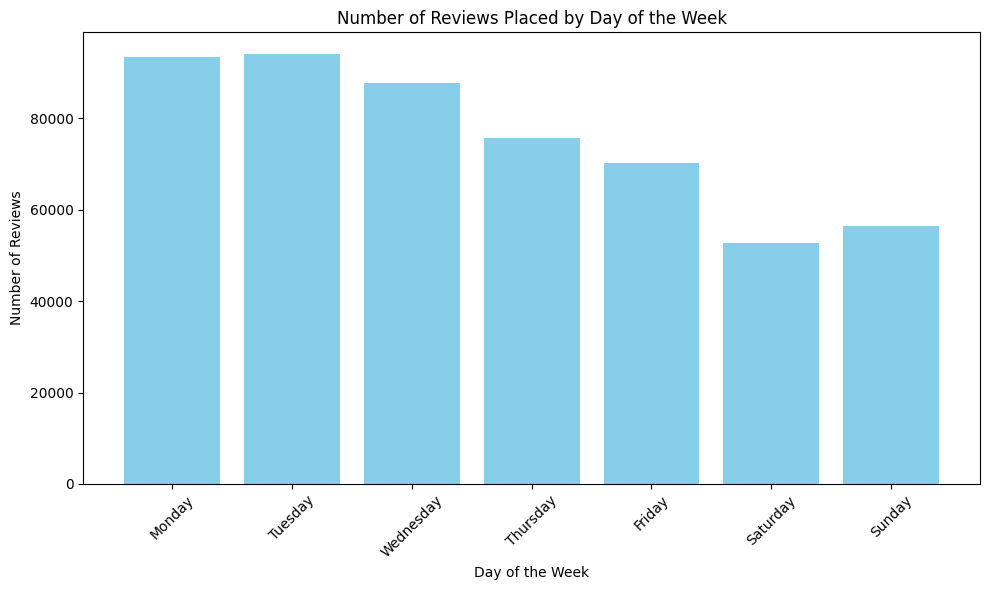

In [13]:
# Get the weekday (0: Monday, 1: Tuesday, ..., 6: Sunday)
weekdays = review_df['Date'].dt.dayofweek

# Count the occurrences of each weekday
weekday_counts = np.bincount(weekdays)

# Plot the distribution of reviews by day of the week
plt.figure(figsize=(10, 6))
plt.bar(range(7), weekday_counts, color='skyblue')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Reviews')
plt.title('Number of Reviews Placed by Day of the Week')
plt.xticks(range(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=45)
plt.tight_layout()
plt.show();

Most reviews were made on Tuesdays.

### Which movie has the highest average rating?

In [14]:
# extract review dates, user IDs, and ratings using NumPy
review_data = sampled_df['review_data'].values
review_dates = np.concatenate([np.array([entry['date'] for entry in row]) for row in review_data])
user_ids = np.concatenate([np.array([entry['userId'] for entry in row]) for row in review_data])
ratings = np.concatenate([np.array([entry['rating'] for entry in row]) for row in review_data])

# Convert review_dates to pandas datetime objects
review_dates = pd.to_datetime(review_dates)

# Extract movie titles
titles = np.concatenate([[title] * len(row) for title, row in zip(sampled_df['title'], review_data)])

# Create a DataFrame with review dates, user IDs, ratings, and movie titles
review_df = pd.DataFrame({'Date': review_dates, 'User_ID': user_ids, 'Rating': ratings, 'Movie_Title': titles})

In [15]:
review_df.groupby('Movie_Title')['Rating'].mean().sort_values(ascending=False).head(10)
print('{} is the best rated movie on average in this sample.'.format(review_df.groupby('Movie_Title')['Rating'].mean().idxmax()))

Movie_Title
Star Trek: Enterprise: Season 3                   4.191676
Yojimbo                                           4.031540
Dragon Ball: Piccolo Jr. Saga: Part 1             3.996292
Dragon Ball: Tournament Saga                      3.984444
Rabbit-Proof Fence                                3.973709
All in the Family: Season 4                       3.963095
The Game                                          3.853032
Roger & Me                                        3.843813
Poltergeist                                       3.826155
The Vicar of Dibley: 10th Anniversary Specials    3.788660
Name: Rating, dtype: float64

Star Trek: Enterprise: Season 3 is the best rated movie on average in this sample.


In [16]:
# see which movie has received the most amount of reviews and how many unique users have reviewed a movie
review_df['Movie_Title'].value_counts().head(10)
print('{} has received the highest amount of reviews in this sample.'.format(review_df['Movie_Title'].value_counts().idxmax()))
review_df.groupby('Movie_Title')['User_ID'].nunique().sort_values(ascending=False).head(10)
print('Above, the unique users that gave a review per movie is computed. The values match up exactly with the amount of reviews per movie, indicating no user has reviewed a movie twice.')

Movie_Title
American Wedding                 61019
Robin Hood: Prince of Thieves    44001
Dr. Dolittle 2                   42113
Poltergeist                      40841
The Game                         38362
Rabbit-Proof Fence               36515
Taxi                             32027
Wild Things                      27038
Roger & Me                       26718
Star Trek: The Motion Picture    20487
Name: count, dtype: int64

American Wedding has received the highest amount of reviews in this sample.


Movie_Title
American Wedding                 61019
Robin Hood: Prince of Thieves    44001
Dr. Dolittle 2                   42113
Poltergeist                      40841
The Game                         38362
Rabbit-Proof Fence               36515
Taxi                             32027
Wild Things                      27038
Roger & Me                       26718
Star Trek: The Motion Picture    20487
Name: User_ID, dtype: int64

Above, the unique users that gave a review per movie is computed. The values match up exactly with the amount of reviews per movie, indicating no user has reviewed a movie twice.


### Handle outliers/distributions:

<Figure size 600x500 with 0 Axes>

<Axes: >

Text(0.5, 0.95, 'Histograms of Movie Release dates')

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Frequency')

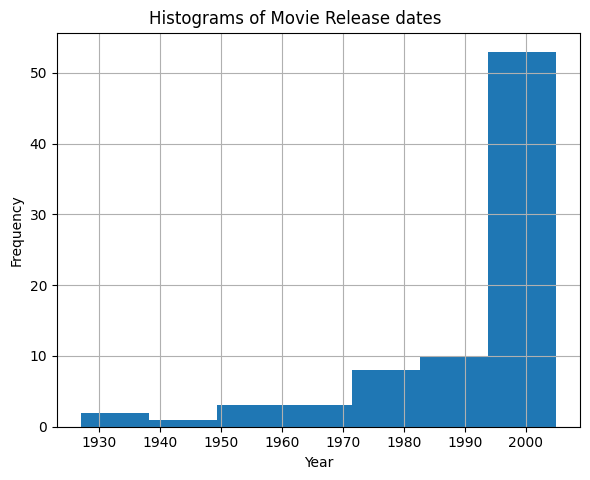

In [17]:
# Plot histogram with bins spanning 10 years
sampled_df['year'] = sampled_df['year'].astype(int)
plt.figure(figsize=(6, 5))
sampled_df['year'].hist(bins=int((sampled_df['year'].max() - sampled_df['year'].min()) / 10), figsize=(6, 5))
plt.suptitle('Histograms of Movie Release dates', y=0.95)
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

Data is skewed, as most records are released during the 90s and 00s.

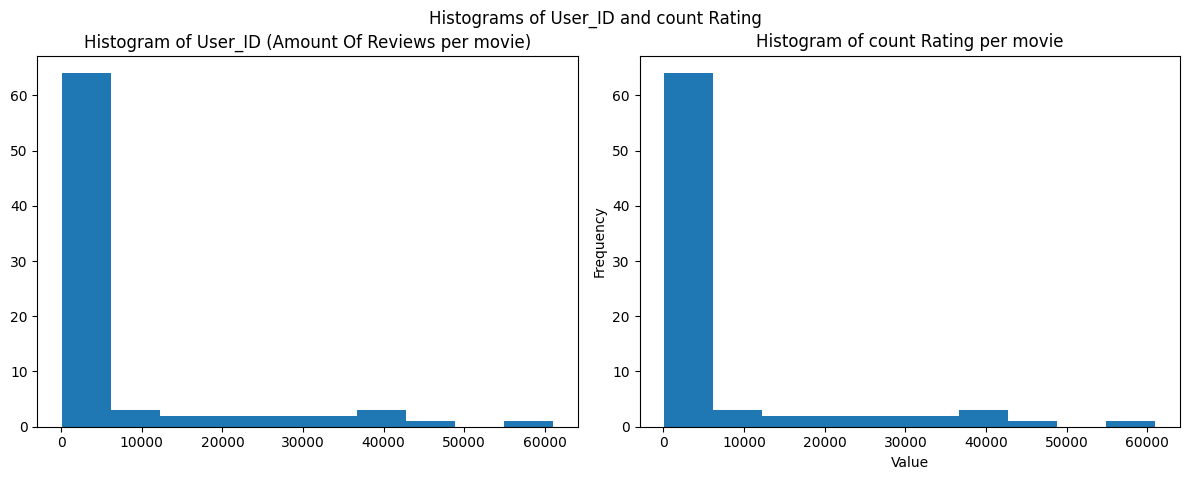

In [18]:
# Group by 'Movie_Title' and calculate count of User_ID and mean of Rating
result_df = review_df.groupby('Movie_Title').agg({'User_ID': 'count', 'Rating': 'count'}).reset_index()

# Plot histograms for 'User_ID' and 'Rating'
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Histogram for 'User_ID'
axs[0].hist(result_df['User_ID'])
axs[0].set_title('Histogram of User_ID (Amount Of Reviews per movie)')

# Histogram for 'Rating'
axs[1].hist(result_df['Rating'])
axs[1].set_title('Histogram of count Rating per movie')

# Setting common attributes
plt.suptitle('Histograms of User_ID and count Rating', y=0.95)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show();

Amount of reviews per movieId is skewed, avg rating per movie seems approx. normally distributed.

In [19]:
result_df

,Movie_Title,User_ID,Rating
0,All in the Family: Season 4,840,840
1,American Adobo,479,479
2,American Wedding,61019,61019
3,Baby Human,141,141
4,Beyblade: Fierce Battle,165,165
...,...,...,...
75,Voltage Fighter Gowcaizer,108,108
76,What's the Matter with Helen? / Whoever Slew A...,186,186
77,Wild Things,27038,27038
78,Year of the Horse: Neil Young & Crazy Horse Live,804,804


Amount of reviews is highly skewed, indicating lots of movies with low amounts to no reviews.

AVG Rating is normally distributed, meaning the ratings across movies in the dataset are normally deviating around the mean.

### **Outliers**

Outliers in amount of reviews and release date will not be removed, as they represent users connected to those movies. Those represent a real-world variability which cannot be excluded. 

Furthermore, robust recommender systems should be able to adapt to these outliers and represent valuable information to those users as well. Removing this information would also mean that the model cannot be trained on those.

As the user-item matrix will be sparse, removing outliers would further reduce the size of the data which the model can use to train, which would make it more challenging to build a reliable recommender system.

## Check for association with time and ratings:

Hypothese before doing ANOVA:

- **H0**: means of groups across months of the year are **equal**, meaning there **IS NO** correlation between the time of the year and the avg. rating.
- **Ha**: means of groups across months of the year are **NOT equal**, meaning there **IS** correlation between the time of the year and the avg. rating.

In [20]:
# force data into category format and change to month notation to compare months with avg rating
df_anova = review_df[['Date', 'User_ID', 'Rating', 'Movie_Title']]
df_anova['Date'] = (df_anova['Date'].dt.strftime('%B')).astype('category')
df_anova

,Date,User_ID,Rating,Movie_Title
0,March,1575876,4.0,Unhook the Stars
1,October,1862608,1.0,Unhook the Stars
2,January,1447354,4.0,Unhook the Stars
3,October,466862,4.0,Unhook the Stars
4,April,429382,3.0,Unhook the Stars
...,...,...,...,...
530492,November,2513682,4.0,Wild Things
530493,December,1021583,3.0,Wild Things
530494,December,1272199,4.0,Wild Things
530495,December,1704768,5.0,Wild Things


In [21]:
alpha = 0.05 # set confidence level at 95%

# Perform ANOVA
f_statistic, p_value = f_oneway(*[group['Rating'] for _, group in df_anova.groupby('Date')])

print("F-Statistic:", f_statistic)
print("P-value:", p_value)

if p_value < alpha:
    print("Not enough evidence to retain H0, so H0 will be dropped and Ha applies, meaning months of the year have significant correlation with the avg. reviews per movie.")
else:
    print("Enough evidence to retain H0, so H0 will be applied and Ha dropped, meaning months of the year DO NOT have significant correlation with the avg. reviews per movie.")

C:\Users\Jaume\AppData\Local\Temp\ipykernel_6744\3653377720.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  f_statistic, p_value = f_oneway(*[group['Rating'] for _, group in df_anova.groupby('Date')])


F-Statistic: 74.52673269552344
P-value: 1.449955943494283e-168
Not enough evidence to retain H0, so H0 will be dropped and Ha applies, meaning months of the year have significant correlation with the avg. reviews per movie.


#### Check assumptions ANOVA:

**Normality residuals assumption check:**

C:\Users\Jaume\AppData\Local\Temp\ipykernel_6744\3545725209.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, group in sample_df.groupby('Date'):


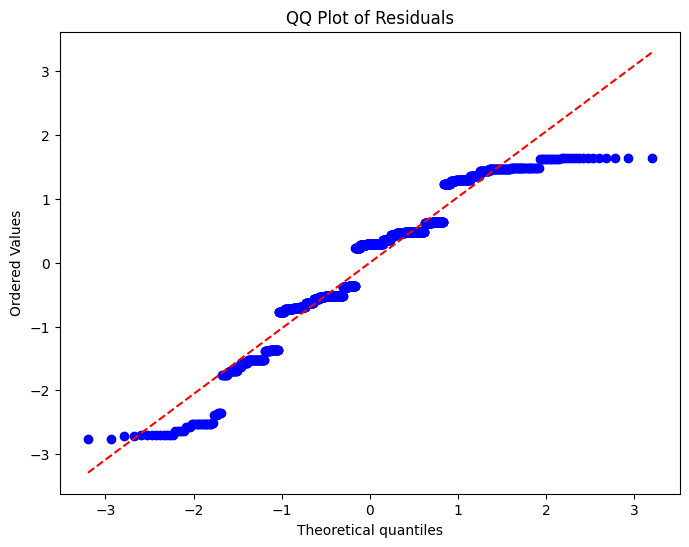

In [22]:
from scipy.stats import shapiro, levene
import scipy.stats as stats

# Get a random sample of 1000 observations from df_anova to get a accurate result in shaprio and levene test
sample_df = df_anova.sample(n=1000, random_state=42)

# Get residuals
residuals = []
for _, group in sample_df.groupby('Date'):
    residuals.extend(group['Rating'] - group['Rating'].mean())

# QQ plot
fig, ax = plt.subplots(figsize=(8, 6))
stats.probplot(residuals, dist="norm", plot=ax)
ax.get_lines()[1].set_linestyle('--')  # add a dashed line to compare against normal distribution
ax.set_title('QQ Plot of Residuals')
plt.show();

In [23]:
# Shapiro-Wilk test for normality
_, shapiro_p_value = shapiro(residuals)
if shapiro_p_value > alpha:
    print("Residuals are normally distributed (normality assumption is met).")
else:
    print("Residuals are not normally distributed (normality assumption may be violated).")

Residuals are not normally distributed (normality assumption may be violated).


The variances are approximately lineair in the QQ-plot, even though the gaps between the groups suggest deviations in normality. Therefore, there is evidence to suggest that this assumption of ANOVA is not violated and that the residuals follow a normal distribution. The Shapiro test says otherwise, meaning this violation is violated.

**Homogeneity of variances assumption check:**

In [24]:
# Levene's test for homogeneity of variances
levene_statistic, levene_p_value = levene(*[group['Rating'] for _, group in sample_df.groupby('Date')])
if levene_p_value > alpha:
    print("Variances of residuals are approximately equal across all groups (homogeneity of variances assumption is met).")
else:
    print("Variances of residuals are not equal across all groups (homogeneity of variances assumption may be violated).")

Variances of residuals are approximately equal across all groups (homogeneity of variances assumption is met).


C:\Users\Jaume\AppData\Local\Temp\ipykernel_6744\865908296.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  levene_statistic, levene_p_value = levene(*[group['Rating'] for _, group in sample_df.groupby('Date')])


As the residuals assumption is violated, the kruskal wallis test is needed to further investigate the validity of ANOVA results:

In [25]:
from scipy.stats import kruskal

# Perform Kruskal-Wallis test
kruskal_statistic, kruskal_p_value = kruskal(*[group['Rating'] for _, group in df_anova.groupby('Date')])

print("Kruskal-Wallis Statistic:", kruskal_statistic)
print("P-value:", kruskal_p_value)

alpha = 0.05 # Set confidence level at 95%
if kruskal_p_value < alpha:
    print("Reject the null hypothesis. There is enough evidence to suggest that there are significant differences between the groups. Therefore, there IS enough evidence to suggest month of the year has significant correlation with avg. rating.")
else:
    print("Fail to reject the null hypothesis. There IS NOT enough evidence to suggest that there are significant differences between the groups across months of the year. Therefore, there is NOT enough evidence to suggest month of the year has significant correlation with avg. rating.")


C:\Users\Jaume\AppData\Local\Temp\ipykernel_6744\1833443547.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  kruskal_statistic, kruskal_p_value = kruskal(*[group['Rating'] for _, group in df_anova.groupby('Date')])


Kruskal-Wallis Statistic: 778.9444225483519
P-value: 6.276089711143588e-160
Reject the null hypothesis. There is enough evidence to suggest that there are significant differences between the groups. Therefore, there IS enough evidence to suggest month of the year has significant correlation with avg. rating.


### Genre association with ratings:

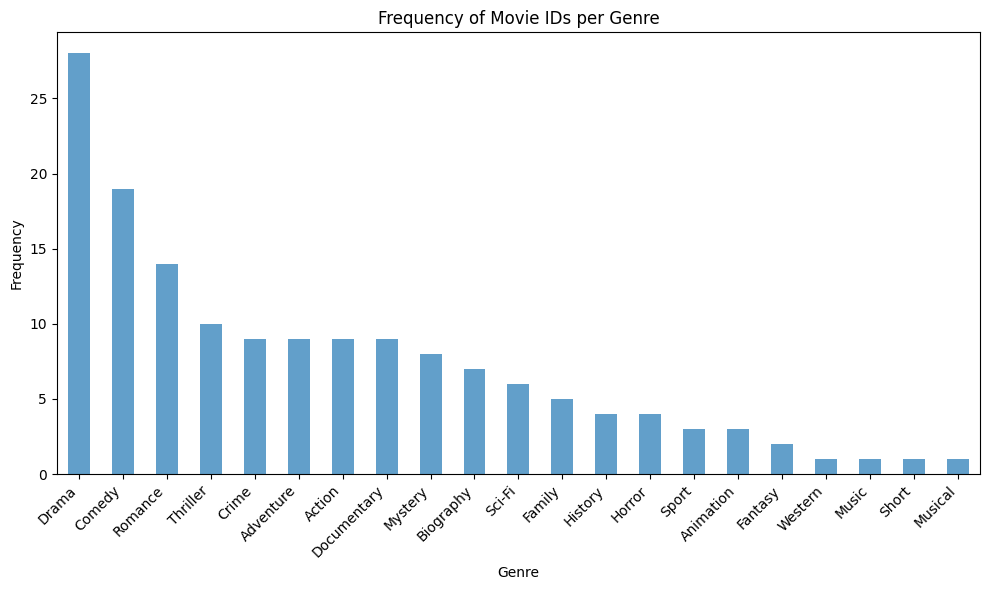

In [26]:
genres_list = sampled_df['genres'].explode().dropna()

# Count the frequencies of each genre
genre_counts = genres_list.value_counts()

# Plot the frequencies
plt.figure(figsize=(10, 6))
genre_counts.plot(kind='bar', alpha=0.7)
plt.xlabel('Genre')
plt.ylabel('Frequency')
plt.title('Frequency of Movie IDs per Genre')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show();

In [27]:
# Print the result
print("The genre with the maximum amount of reviews in this sample is:", genre_counts.idxmax())

The genre with the maximum amount of reviews in this sample is: Drama


Let's also lok at which genre had the highest avg. amount of reviews:

In [28]:
genres_df = sampled_df.explode('genres')
genres_df.groupby('genres')['num_reviews'].mean().sort_values(ascending=False)
print("The genre with the highest avg. given reviews in this sample is:", genres_df.groupby('genres')['num_reviews'].mean().idxmax())

genres
Fantasy        21506.000000
Thriller       17895.500000
Horror         16674.000000
Action         15629.222222
Mystery        13315.625000
Adventure      12476.222222
Crime          11155.555556
History        10889.000000
Comedy         10425.052632
Family         10379.200000
Drama           7946.142857
Sci-Fi          7508.500000
Romance         6900.428571
Biography       6663.857143
Documentary     3596.666667
Short           2549.000000
Animation       2267.666667
Musical         2083.000000
Sport           1415.333333
Music            804.000000
Western          113.000000
Name: num_reviews, dtype: float64

The genre with the highest avg. given reviews in this sample is: Fantasy


In [29]:
# Calculate average rating for each genre
genre_avg_ratings = genres_df.explode('review_data').groupby('genres')['review_data'].apply(lambda x: x.apply(lambda y: y['rating']).mean()).sort_values(ascending=False)

print("Average Ratings for Each Genre:")
print(genre_avg_ratings)
print()
print(f'{genre_avg_ratings.idxmax().upper()} is the genre with the highest avg. rating given by users.')

Average Ratings for Each Genre:
genres
History        3.912044
Biography      3.889746
Musical        3.711954
Documentary    3.709947
Sport          3.709609
Adventure      3.707239
Drama          3.699544
Action         3.619857
Thriller       3.613210
Mystery        3.569951
Romance        3.558185
Horror         3.520676
Animation      3.391151
Crime          3.384552
Comedy         3.347604
Sci-Fi         3.211960
Fantasy        3.116316
Family         3.097927
Western        3.017699
Music          2.986318
Short          2.761867
Name: review_data, dtype: float64

HISTORY is the genre with the highest avg. rating given by users.


In [30]:
# Assuming genre_rating_counts is already calculated
genre_rating_counts = genres_df.explode('review_data').groupby('genres')['review_data'].apply(lambda x: x.apply(lambda y: y['rating']).count()).sort_values(ascending=False)

# Create DataFrame from genre_rating_counts
genre_ratings_df = pd.DataFrame(genre_rating_counts).reset_index()
genre_ratings_df.columns = ['Genre', 'Number of Ratings']

# Perform Kruskal-Wallis test
kruskal_statistic, kruskal_p_value = kruskal(*[group['Number of Ratings'] for _, group in genre_ratings_df.groupby('Genre')])

print("Kruskal-Wallis Statistic:", kruskal_statistic)
print("P-value:", kruskal_p_value)

alpha = 0.05 # Set confidence level at 95%
if kruskal_p_value < alpha:
    print("Reject the null hypothesis. There is enough evidence to suggest that there are significant differences between the groups.\nTherefore, there IS enough evidence to suggest that genre has a significant correlation with the number of ratings.")
else:
    print("Fail to reject the null hypothesis. There IS NOT enough evidence to suggest that there are significant differences between the groups across genres.\nTherefore, there is NOT enough evidence to suggest that genre has a significant correlation with the number of ratings.")


Kruskal-Wallis Statistic: 20.0
P-value: 0.4579297144718523
Fail to reject the null hypothesis. There IS NOT enough evidence to suggest that there are significant differences between the groups across genres.
Therefore, there is NOT enough evidence to suggest that genre has a significant correlation with the number of ratings.


In [31]:
sampled_df.to_parquet('cleaned/strat_sample_netflix')

## Handle null values:

Already handled in the joining.ipynb file. There are no null values in the Netflix Prize Dataset to handle.